In [1]:
using Distributed
addprocs(5);

In [2]:
@everywhere import Plots
@everywhere include("shallow_water.jl")

**Assumption:**<br />
This code assumes that each process owns a subgrid of the same shape. The process topologies (see below) must yield integer row and column sizes:<br />

$\frac{L}{\Delta x \cdot n_\text{rows}} \in \mathbb{N}$ and $\frac{L}{\Delta x \cdot n_\text{cols}} \in \mathbb{N}$,

where $n_\text{rows}, n_\text{cols}$ are the number of processes in the process grid.<br />
We had a topology of (2, 2) in the prediscussion slides.

# Parameters

In [3]:
@everywhere g = 9.81
@everywhere b = 0.3
@everywhere ν = 0.3

@everywhere Δx = 0.5
@everywhere Δt = 0.01
@everywhere L = 120

@everywhere A = 1.
@everywhere σ = 5.

# Total linear grid size; each process only has a part of this!
@everywhere N = Int64(ceil(L / Δx))
@everywhere n_steps = 5000;

# Setup neighbour indices for communication

In [4]:
@everywhere process_topologies = Dict(
    1 => (1, 1),
    2 => (1, 2),
    3 => (1, 3),
    4 => (2, 2),
    5 => (1, 5),
    6 => (2, 3),
)

In [5]:
@everywhere @show n_proc_rows, n_proc_cols = process_topologies[nprocs()]
@everywhere @show neighbours = get_neighbours(n_proc_rows, n_proc_cols);

(n_proc_rows, n_proc_cols) = process_topologies[nprocs()] = (2, 3)
      From worker 5:	(n_proc_rows, n_proc_cols) = process_topologies[nprocs()] = (2, 3)
      From worker 6:	(n_proc_rows, n_proc_cols) = process_topologies[nprocs()] = (2, 3)
      From worker 4:	(n_proc_rows, n_proc_cols) = process_topologies[nprocs()] = (2, 3)
      From worker 2:	(n_proc_rows, n_proc_cols) = process_topologies[nprocs()] = (2, 3)
      From worker 3:	(n_proc_rows, n_proc_cols) = process_topologies[nprocs()] = (2, 3)
neighbours = get_neighbours(n_proc_rows, n_proc_cols) = Dict("left" => 3,"bottom" => 4,"right" => 2,"top" => 4)
      From worker 5:	neighbours = get_neighbours(n_proc_rows, n_proc_cols) = Dict("left" => 4,"bottom" => 2,"right" => 6,"top" => 2)
      From worker 3:	neighbours = get_neighbours(n_proc_rows, n_proc_cols) = Dict("left" => 2,"bottom" => 6,"right" => 1,"top" => 6)
      From worker 6:	neighbours = get_neighbours(n_proc_rows, n_proc_cols) = Dict("left" => 5,"bottom" => 3,"right"

In [6]:
@everywhere function get_grid()
    return grid
end

# Simulate

In [7]:
@everywhere grid = simulate_parallel(N, L, Δx, Δt, g, b, ν, 20, A, σ, n_proc_rows, n_proc_cols);

# Collect results for plotting

In [8]:
full_grid = Array{Float64}(undef, (N, N, 3))

for id in 1:nprocs()
    row_id = process_id_to_row(id, n_proc_cols) - 1
    col_id = process_id_to_col(id, n_proc_cols) - 1
    
    # We know that all the processes have the same grid size.
    grid_size = size(grid) .- (2, 2, 0)

    subgrid = remotecall_fetch(get_grid, id)
    
    row_start = row_id*grid_size[1] + 1
    row_end = row_id*grid_size[1] + grid_size[1]
    col_start = col_id*grid_size[2] + 1
    col_end = col_id*grid_size[2] + grid_size[2]
    
    println("Fetching range ($(row_start):$(row_end), $(col_start):$(col_end)) for process $(id)")

    full_grid[row_start:row_end, col_start:col_end, :] .= subgrid[2:end-1, 2:end-1, :]
end

Fetching range (1:120, 1:80) for process 1
Fetching range (1:120, 81:160) for process 2
Fetching range (1:120, 161:240) for process 3
Fetching range (121:240, 1:80) for process 4
Fetching range (121:240, 81:160) for process 5
Fetching range (121:240, 161:240) for process 6


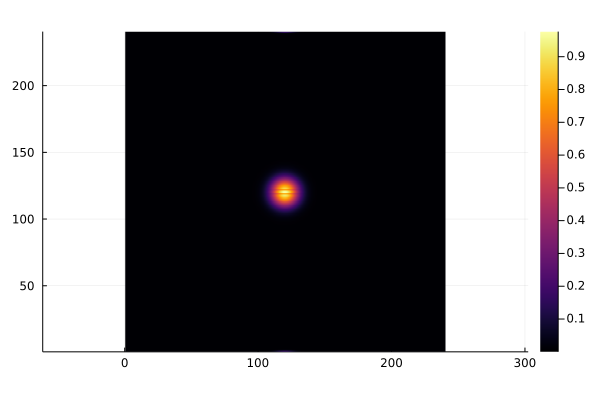

In [9]:
Plots.heatmap(full_grid[:, :, 1], aspectratio=1)